## Global Forest Watch Fires data

Example of extracting the time series of counts per country from the GFW fires report data (e.g. [from Spain]( http://fires.globalforestwatch.org/report/index.html#aoitype=GLOBAL&reporttype=globalcountryreport&country=Spain&aois=Andalucía!Aragón!Cantabria!Castilla y León!Castilla-La Mancha!Cataluña!Ceuta y Melilla!Comunidad Foral de Navarra!Comunidad Valenciana!Comunidad de Madrid!Extremadura!Galicia!Islas Baleares!Islas Canarias!La Rioja!País Vasco!Principado de Asturias!Región de Murcia&dates=fYear-2017!fMonth-6!fDay-25!tYear-2017!tMonth-7!tDay-2)), and using that to create contextual info for current fires.

In [127]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

In [2]:
## URL for ESP
url = "http://gis-gfw.wri.org/arcgis/rest/services/Fires/FIRMS_Global/MapServer/9/query?f=json&where=ID_0%20%3D%20215%20AND%20NAME_1%20in%20(%27Andaluc%C3%ADa%27%2C%27Arag%C3%B3n%27%2C%27Cantabria%27%2C%27Castilla%20y%20Le%C3%B3n%27%2C%27Castilla-La%20Mancha%27%2C%27Catalu%C3%B1a%27%2C%27Ceuta%20y%20Melilla%27%2C%27Comunidad%20Foral%20de%20Navarra%27%2C%27Comunidad%20Valenciana%27%2C%27Comunidad%20de%20Madrid%27%2C%27Extremadura%27%2C%27Galicia%27%2C%27Islas%20Baleares%27%2C%27Islas%20Canarias%27%2C%27La%20Rioja%27%2C%27Pa%C3%ADs%20Vasco%27%2C%27Principado%20de%20Asturias%27%2C%27Regi%C3%B3n%20de%20Murcia%27)&returnGeometry=false&spatialRel=esriSpatialRelIntersects&groupByFieldsForStatistics=ACQ_DATE&orderByFields=ACQ_DATE%20ASC&outStatistics=%5B%7B%22statisticType%22%3A%22count%22%2C%22onStatisticField%22%3A%22ACQ_DATE%22%2C%22outStatisticFieldName%22%3A%22Count%22%7D%5D&callback=dojo.io.script.jsonp_dojoIoScript3._jsonpCallback"
url

'http://gis-gfw.wri.org/arcgis/rest/services/Fires/FIRMS_Global/MapServer/9/query?f=json&where=ID_0%20%3D%20215%20AND%20NAME_1%20in%20(%27Andaluc%C3%ADa%27%2C%27Arag%C3%B3n%27%2C%27Cantabria%27%2C%27Castilla%20y%20Le%C3%B3n%27%2C%27Castilla-La%20Mancha%27%2C%27Catalu%C3%B1a%27%2C%27Ceuta%20y%20Melilla%27%2C%27Comunidad%20Foral%20de%20Navarra%27%2C%27Comunidad%20Valenciana%27%2C%27Comunidad%20de%20Madrid%27%2C%27Extremadura%27%2C%27Galicia%27%2C%27Islas%20Baleares%27%2C%27Islas%20Canarias%27%2C%27La%20Rioja%27%2C%27Pa%C3%ADs%20Vasco%27%2C%27Principado%20de%20Asturias%27%2C%27Regi%C3%B3n%20de%20Murcia%27)&returnGeometry=false&spatialRel=esriSpatialRelIntersects&groupByFieldsForStatistics=ACQ_DATE&orderByFields=ACQ_DATE%20ASC&outStatistics=%5B%7B%22statisticType%22%3A%22count%22%2C%22onStatisticField%22%3A%22ACQ_DATE%22%2C%22outStatisticFieldName%22%3A%22Count%22%7D%5D&callback=dojo.io.script.jsonp_dojoIoScript3._jsonpCallback'

In [3]:
r = requests.get(url)
r.status_code
text = r.text
x = text.split('dojo.io.script.jsonp_dojoIoScript3._jsonpCallback(')[1][:-2]
d = json.loads(x)

In [4]:
# Parse the data, transform from microseconds since 1970,01,01 to datetime, and add data into a dataframe
date = []
count = []
for row in d.get('features'):
    tmp = row.get('attributes')
    date.append( pd.datetime.fromtimestamp( tmp.get('ACQ_DATE') / 1e3))
    count.append(tmp.get('Count'))
df = pd.DataFrame(count, index=date, columns=['count'])

In [5]:
df.head()

,count
2012-01-01 01:00:00,19
2012-01-02 01:00:00,4
2012-01-03 01:00:00,8
2012-01-05 01:00:00,9
2012-01-06 01:00:00,4


In [6]:
df.tail()

,count
2017-06-29 02:00:00,23
2017-06-30 02:00:00,15
2017-07-01 02:00:00,1
2017-07-02 02:00:00,13
2017-07-03 02:00:00,1


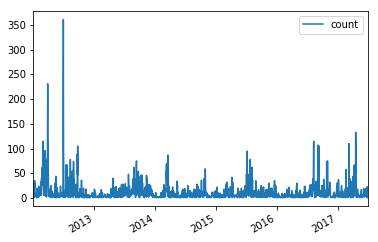

In [7]:
df.plot()

These data have a strong seasonality. We can:

1. Ignore it and make a simple percentile rank against all data.

2. Make a percentile rank against data while considering seasonality (this is harder to make generic, as seasonality differs with location). 

2. Consider seasonality explicitly, and make an anomaly against a smooth or DOY mean

## Percentile rank

When given X counts/day, show the percentile rank based on historical data. 

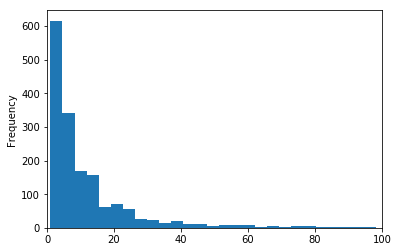

In [8]:
df['count'].plot(kind='hist', bins=100, xlim=(0,100))

In [12]:
from scipy import stats

In [59]:
historical_data = df['count'].values
start = df.index[0]
end = df.index[-1]

current_count = 5

percentile = stats.percentileofscore(historical_data, current_count)
percentile_invert = 100 - percentile

print("FIRES")
print("Detected {0:g} counts/day over A.O.I: {1:3.0f}% of days over the period of {2} to {3} had more fires.".format(current_count, percentile_invert,start.date(), end.date()))

FIRES
Detected 5 counts/day over A.O.I:  59% of days over the period of 2012-01-01 to 2017-07-03 had more fires.


## DOY mean and anomaly

Now let's get more complicated: 
1. calculate DOY mean from historical period
2. calculate anomaly of any day relative to DOY mean

In [63]:
tmp = df.index[0]

In [68]:
tmp.dayofyear

1

In [87]:
# First, add a DOY index to the df

tmp_doy = []
for row in df.index:
    tmp_doy.append(row.dayofyear)
df['doy'] = tmp_doy

In [89]:
df.head()

,count,doy
2012-01-01 01:00:00,19,1
2012-01-02 01:00:00,4,2
2012-01-03 01:00:00,8,3
2012-01-05 01:00:00,9,5
2012-01-06 01:00:00,4,6


In [122]:
# Use the doy index to find all DOY values and average
# These will have really small sample sizes which may be a problem here
doy_mean = {}
for doy in range(1, 367):
    doy_positions = df['doy'] == doy
    doy_mean[doy] = np.nanmean(df[doy_positions]['count'].values)

/Users/Ben/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Ben/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Used a dictionary approach as it will be easy to apply these data back to the DF based on the DOY index we created if desired. First let's just check these data.

In [125]:
doy_val = []
for k in doy_mean:
    doy_val.append(doy_mean[k])

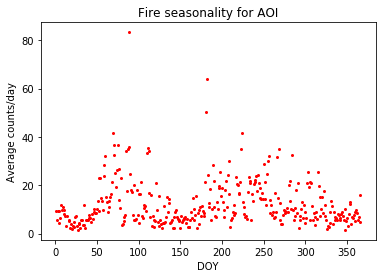

In [134]:
plt.plot(range(1,367),doy_val,'ro',ms=2.)
plt.xlabel('DOY')
plt.ylabel('Average counts/day')
plt.title("Fire seasonality for AOI")

## Rolling mean approach

Based on what I am seeing with DOY values, it looks like the seasonal data are noisey as there only a few datapoints for each day. Therefore we can instead try a smooth approach and show a difference relative to the past 30 days.

In [209]:
df['smooth'] = pd.rolling_mean(df['count'], window=30, min_periods=0, center = False)

/Users/Ben/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=0,window=30).mean()
  if __name__ == '__main__':


In [211]:
p = figure(x_axis_type="datetime", title="Fires and Smooth filter", plot_width=800, plot_height=400)
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Count'

p.circle(df.index, df['count'], size=2, legend='fires',
          color='red', alpha=0.2)

p.line(df.index, df['smooth'], legend='Smooth filter', color='navy')
p.legend.location = "top_left"

show(p)

In [227]:
time = df.index[400]                    # extract a random time index to test
anom = df['count'][time] -  df['smooth'][time]       # difference the counts on that day by the filter to get anomaly
print("FIRES")
if anom < 0:
    print("On {0} {1} fire pixels detected: {2:3.2f} less fire areas than the previous 30-day moving trend.".format(time.date(),df['count'][time], anom))
else:
    print("On {0} {1} fire pixels detected: {2:3.2f} more fire areas than the previous 30-day moving trend.".format(time.date(),df['count'][time], anom))

FIRES
On 2013-05-17 5 fire pixels detected: -4.77 less fire areas than the previous 30-day moving trend.
